In [1]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img1 = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [2]:
im_daisy = load_images_from_folder('data/flower_photos/daisy')

im_tulips = load_images_from_folder('data/flower_photos/tulips')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

42


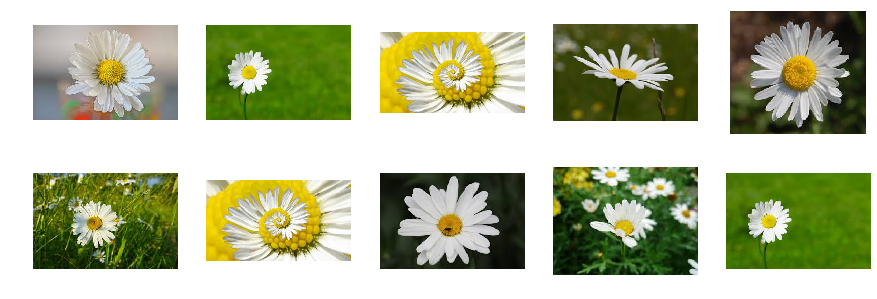

In [4]:
print(len(im_daisy))
samples_per_row = 5
num_rows = 2

# Function to visualize some of the images of our dataset
fig, axis = plt.subplots(num_rows,samples_per_row,figsize=(15,5))
#fig.axis('off')
n_train = len(im_daisy)
for row in axis:
    for col in row:
        idx = np.random.randint(0, n_train)
        col.imshow(im_daisy[idx]) 
        col.axis('off')

65


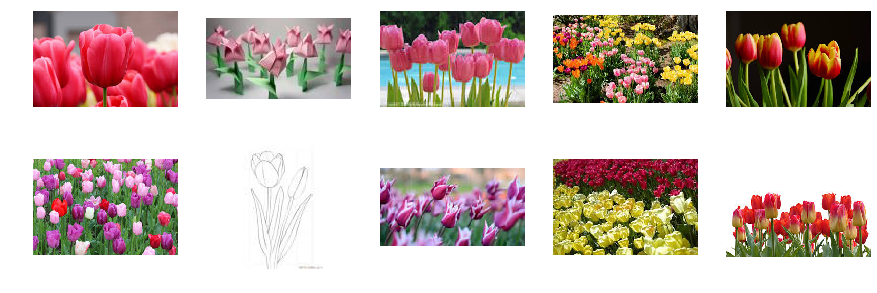

In [5]:
print(len(im_tulips))
samples_per_row = 5
num_rows = 2

# Function to visualize some of the images of our dataset
fig, axis = plt.subplots(num_rows,samples_per_row,figsize=(15,5))
#fig.axis('off')
n_train = len(im_tulips)
for row in axis:
    for col in row:
        idx = np.random.randint(0, n_train)
        col.imshow(im_tulips[idx]) 
        col.axis('off')

In [6]:
import os
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.3.0-spark2.4-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [7]:
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder \
      .appName("ImageClassification") \
      .config("spark.executor.memory", "70g") \
      .config("spark.driver.memory", "50g") \
      .config("spark.memory.offHeap.enabled",True) \
      .config("spark.memory.offHeap.size","16g") \
      .getOrCreate()



In [9]:
import pyspark.sql.functions as f
import sparkdl as dl
from pyspark.ml.image import ImageSchema
from sparkdl.image import imageIO

Using TensorFlow backend.


In [10]:
dftulips = ImageSchema.readImages('data/flower_photos/tulips').withColumn('label', f.lit(0))

dfdaisy = ImageSchema.readImages('data/flower_photos/daisy').withColumn('label', f.lit(1))


In [11]:
dfdaisy.show(5)

+--------------------+-----+
|               image|label|
+--------------------+-----+
|[file:/home/am/Dr...|    1|
|[file:/home/am/Dr...|    1|
|[file:/home/am/Dr...|    1|
|[file:/home/am/Dr...|    1|
|[file:/home/am/Dr...|    1|
+--------------------+-----+
only showing top 5 rows



In [12]:
dftulips.show(5)

+--------------------+-----+
|               image|label|
+--------------------+-----+
|[file:/home/am/Dr...|    0|
|[file:/home/am/Dr...|    0|
|[file:/home/am/Dr...|    0|
|[file:/home/am/Dr...|    0|
|[file:/home/am/Dr...|    0|
+--------------------+-----+
only showing top 5 rows



In [13]:
trainDFdaisy, testDFdaisy = dfdaisy.randomSplit([0.70,0.30], seed = 123)
trainDFtulips, testDFtulips = dftulips.randomSplit([0.70,0.30], seed = 122)

In [14]:
trainDF = trainDFdaisy.unionAll(trainDFtulips)
testDF = testDFdaisy.unionAll(testDFtulips)

#trainDF = trainDF.repartition(100)  #required when dataset is large
#testDF = testDF.repartition(100)

In [15]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
vectorizer = dl.DeepImageFeaturizer(inputCol="image", outputCol="features", 
                    modelName="InceptionV3")
logreg = LogisticRegression(maxIter=20, labelCol="label")
pipeline = Pipeline(stages=[vectorizer, logreg])
pipeline_model = pipeline.fit(trainDF)


In [16]:
predictDF = pipeline_model.transform(testDF) #predict on test dataset
predictDF.select('prediction', 'label').show(n = testDF.toPandas().shape[0], truncate=False)

+----------+-----+
|prediction|label|
+----------+-----+
|0.0       |0    |
|0.0       |0    |
|1.0       |1    |
|1.0       |1    |
|1.0       |1    |
|1.0       |1    |
|0.0       |1    |
|1.0       |1    |
|1.0       |1    |
|1.0       |1    |
|1.0       |1    |
|1.0       |1    |
|1.0       |1    |
|0.0       |1    |
|1.0       |1    |
|1.0       |1    |
|0.0       |1    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
|0.0       |0    |
+----------+-----+



In [17]:
predictDF.crosstab('prediction', 'label').show()

+----------------+---+---+
|prediction_label|  0|  1|
+----------------+---+---+
|             1.0|  0| 12|
|             0.0| 16|  3|
+----------------+---+---+



In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
scoring = predictDF.select("prediction", "label")
accuracy_score = MulticlassClassificationEvaluator(metricName="accuracy")
rate = accuracy_score.evaluate(scoring)*100
print("accuracy: {}%" .format(round(rate,2)))

accuracy: 90.32%
